In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import lightgbm as lgb

---

# Carga de datos

In [2]:
train_auctions = pd.read_csv("../../features/entrenar_auctions_final.csv")

In [3]:
train_auctions.set_index("device_id", inplace=True)

In [4]:
train_auctions = train_auctions.reindex(sorted(train_auctions.columns), axis=1)

---

In [5]:
X_auctions, y_auctions = train_auctions.drop("target", axis=1), train_auctions["target"]

#filtro_auctions = (X_auctions.T.agg("sum") != 0)
#X_auctions = X_auctions.loc[filtro_auctions]
#y_auctions = y_auctions.loc[filtro_auctions]

X_train_auctions, X_test_auctions, y_train_auctions, y_test_auctions = \
    train_test_split(X_auctions, y_auctions, test_size=0.33, random_state=0)

dtrain_auctions = xgb.DMatrix(data=X_train_auctions, label=y_train_auctions)
dtest_auctions = xgb.DMatrix(data=X_test_auctions, label=y_test_auctions)

---

In [6]:
train_installs = pd.read_csv("../../features/entrenar_installs_final.csv")
train_installs.set_index("device_id", inplace=True)
train_installs = train_installs.reindex(sorted(train_installs.columns), axis=1)

---

In [7]:
X_installs, y_installs = train_installs.drop("target", axis=1), train_installs["target"]
X_train_installs, X_test_installs, y_train_installs, y_test_installs = \
    train_test_split(X_installs, y_installs, test_size=0.33, random_state=0)

#filtro_installs = (X_installs.T.agg("sum") != 0)
#X_installs = X_installs.loc[filtro_installs]
#y_installs = y_installs.loc[filtro_installs]

dtrain_installs = xgb.DMatrix(data=X_train_installs, label=y_train_installs)
dtest_installs = xgb.DMatrix(data=X_test_installs, label=y_test_installs)

---

# XGBoost

In [8]:
# {'colsample_bytree': 0.9500000000000001, 'eta': 0.35000000000000003, 'gamma': 0.9, 'max_depth': 6, 'min_child_weight': 2.0, 'n_estimators': 168}
best_auctions = {
        'n_estimators': 168,
        'eta': 0.35,
        'max_depth': 6,
        'min_child_weight': 2.0,
        'gamma': 0.9,
        'colsample_bytree': 0.95,
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}
model_auctions = xgb.train(best_auctions, dtrain_auctions, verbose_eval=False)

In [9]:
best_installs = {
        'n_estimators': 500,
        'eta': 0.4,
        'max_depth': 7,
        'min_child_weight': 0.5,
        'gamma': 0.65,
        'colsample_bytree': 0.85,
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}
model_installs = xgb.train(best_installs, dtrain_installs, verbose_eval=False)

---

# LightGBM

In [10]:
lgb_auctions = lgb.LGBMRegressor(colsample_bytree=0.7, max_depth=4, n_estimators=150)
lgb_auctions.fit(X_train_auctions, y_train_auctions)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       importance_type='split', learning_rate=0.1, max_depth=4,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
lgb_installs = lgb.LGBMRegressor(colsample_bytree=0.85, max_depth=4, n_estimators=75)
lgb_installs.fit(X_train_installs, y_train_installs)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
       importance_type='split', learning_rate=0.1, max_depth=4,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=75, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

---

In [12]:
pred_auctions_xgb = model_auctions.predict(dtest_auctions)

In [13]:
pred_installs_xgb = model_installs.predict(dtest_installs)

In [14]:
pred_auctions_l = lgb_auctions.predict(X_test_auctions)

In [15]:
pred_installs_l = lgb_installs.predict(X_test_installs)

In [16]:
def rmsetotal(preds_a, preds_i):
    auctions = mean_squared_error(preds_a, y_test_auctions)
    installs = mean_squared_error(preds_i, y_test_installs)
    return sqrt((auctions+installs)/2)

In [17]:
rmsetotal(pred_auctions_xgb, pred_installs_xgb)

69527.95249876527

In [18]:
rmsetotal(pred_auctions_l, pred_installs_l)

69464.47740950913

In [19]:
pred_promedio_a = (0.4*pred_auctions_xgb + 0.6*pred_auctions_l)

In [20]:
pred_promedio_i = (0.4*pred_installs_xgb + 0.6*pred_installs_l)

In [21]:
rmsetotal(pred_promedio_a, pred_promedio_i)

69470.80324410392

# Prueba sesgado

In [13]:
(X_installs.T.agg("sum") == 0).value_counts()

False    737575
True     312769
dtype: int64

In [16]:
minicopia = X_installs.head().copy()

In [21]:
minicopia.T.agg("sum") != 0

device_id
4432995619177048534    True
5904733559638204455    True
896373747754111825     True
3399210824535017892    True
1541425881979513687    True
dtype: bool

In [10]:
X_installs = X_installs.loc[filtro]

In [11]:
y_installs = y_installs.loc[filtro]

In [9]:
filtro = (X_installs.T.agg("sum") != 0)

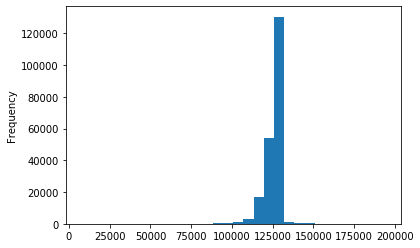

In [22]:
pd.Series(pred_installs_xgb).plot(kind="hist", bins=30)

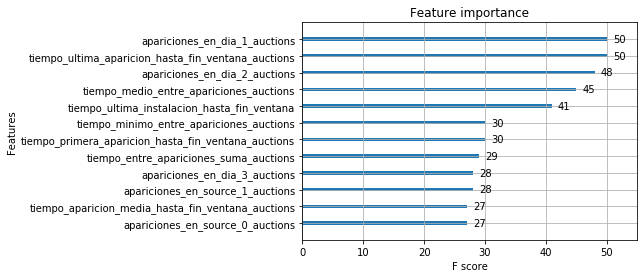

In [36]:
xgb.plot_importance(model_installs, max_num_features=12)